# NLP Project: Hate Speech Detection

## Task 0: Initializing stuff

First, we import and initialize slow-loading libraries used in the rest of the notebook, so we don't have to do that every time we make a change to a cell later on.

We also download our data here.

In [1]:
import utils
import matplotlib.pyplot as plt 
import nltk
import pandas as pd

import pysentiment2 as ps
# Initialize Harvard IV-4 dictionary
hiv4 = ps.HIV4()

# Initialize nltk
nltk.download('punkt')
nltk.download('stopwords')

# Download data if needed
conan_fname = utils.download('https://raw.githubusercontent.com/marcoguerini/CONAN/master/CONAN.json')

conan_json = utils.read_json(conan_fname)
hate_texts, counter_texts = utils.parse_conan(conan_json)

[nltk_data] Downloading package punkt to /Users/uula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/uula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/uula/dev/hatespeech/CONAN.json exists, skipping download


## Task 1 - Word Cloud

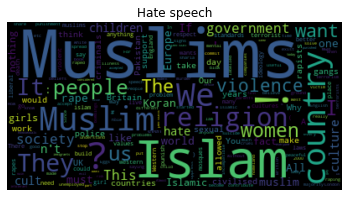

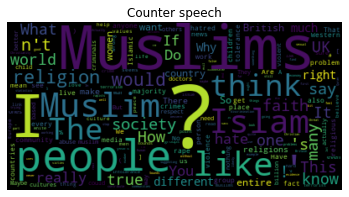

In [2]:
from wordcloud import WordCloud

hate_wc = utils.count_words(hate_texts)
counter_wc = utils.count_words(counter_texts)

for wc, title in [(hate_wc, 'Hate speech'), (counter_wc, 'Counter speech')]:
    wordcloud = WordCloud().generate_from_frequencies(wc)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

## Task 2: Empath analysis

In [3]:
from empath import Empath
lexicon = Empath()

def analyse_texts(texts):
    return {key: value for key, value in lexicon.analyze(texts).items() if value > 0.0}

hate_analysis = analyse_texts(hate_texts)
counter_analysis = analyse_texts(counter_texts)

def pretty_print(analysis, n=10):
    sorted_analysis = [(k, v) for k, v in sorted(analysis.items(), key=lambda i: i[1], reverse=True)]
    for k, v in sorted_analysis[:n]:
        print(f'{k:<18}: {v:>4.0f}')

print('Hate speech'.center(24, '='))
pretty_print(hate_analysis)
print()
print('Counter speech'.center(24, '='))
pretty_print(counter_analysis)

======Hate speech=======
crime             :  729
violence          :  658
religion          :  637
negative_emotion  :  600
law               :  553
aggression        :  536
hate              :  504
worship           :  450
sexual            :  436
government        :  429

=====Counter speech=====
speaking          :  774
negative_emotion  :  723
divine            :  606
positive_emotion  :  579
religion          :  567
communication     :  540
crime             :  501
violence          :  501
trust             :  459
philosophy        :  435


## Task 3: Sentiment analysis

In [4]:
def score_texts(texts):
    return [hiv4.get_score(hiv4.tokenize(text)) for text in texts]

hate_scores = score_texts(hate_texts[:10])
counter_scores = score_texts(counter_texts[:10])

hate_score = pd.DataFrame.from_records(hate_scores).mean().to_dict()
counter_score = pd.DataFrame.from_records(counter_scores).mean().to_dict()

print('Hate speech', hate_score)
print('Counter speech', counter_score)

Hate speech {'Positive': 1.3, 'Negative': 1.1, 'Polarity': 0.2666663777780741, 'Subjectivity': 0.21623374560212727}
Counter speech {'Positive': 2.7, 'Negative': 3.4, 'Polarity': -0.21439555173174768, 'Subjectivity': 0.40034109979783344}
